In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
def import_and_pad_csvs(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    data_arrays = []
    number_arrays = len(csv_files)
    number_large = 0
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    print(f"Index of the largest initial array: {largest_array_index}")
    padded_arrays = []
    for array in data_arrays:
        if array.shape[0] < 64 and array.shape[1] < 64:
            padded_array = np.zeros((64, 64))
            padded_array[:array.shape[0], :array.shape[1]] = array
            padded_arrays.append(padded_array)
            number_large += 1
    print(f'Number of arrays that are smaller than 64x64: {number_large}, ({number_large/number_arrays*100:.2f}%)')
    print(f'max rows: {max_rows}, max cols:{max_cols}')
    combined_array = np.stack(padded_arrays, axis=0)
    return combined_array

In [3]:
class NumpyArrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, 0  # Return only the sample and dummy label

folder_path = 'clusters_colour_rotations'
combined_array = import_and_pad_csvs(folder_path)

scalar = StandardScaler()
combined_array = scalar.fit_transform(combined_array.reshape(-1, 1)).reshape(combined_array.shape)
print(combined_array.shape)


transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = NumpyArrayDataset(combined_array, transform=transform)
print(combined_array.shape)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset = dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Index of the largest initial array: 487
Number of arrays that are smaller than 64x64: 3836, (94.20%)
max rows: 208, max cols:209
(3836, 64, 64)
(3836, 64, 64)


In [86]:
# fig, ax = plt.subplots()
# ax.imshow(combined_array[3929,:,:], cmap='gray')

In [11]:
# class Encoder(nn.Module):
#     def __init__(self, encoded_space_dim):
#         super().__init__()
#         self.encoder_cnn = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 1x211x211 -> 16x106x106
#             nn.ReLU(True),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 16x106x106 -> 32x53x53
#             nn.ReLU(True),
#             nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 32x53x53 -> 64x27x27
#             nn.ReLU(True),
#             nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 64x27x27 -> 128x14x14
#             nn.ReLU(True),
#             nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 128x14x14 -> 256x7x7
#             nn.ReLU(True),
#             nn.Conv2d(256, 512, 3, stride=2, padding=1),  # 256x7x7 -> 512x4x4
#             nn.ReLU(True),
#         )
#         self.flatten = nn.Flatten(start_dim=1)
#         self.encoder_lin = nn.Sequential(
#             nn.Linear(512 * 4 * 4, 1024),
#             nn.ReLU(True),
#             nn.Linear(1024, encoded_space_dim)
#         )

#     def forward(self, x):
#         x = self.encoder_cnn(x)
#         x = self.flatten(x)
#         x = self.encoder_lin(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self, encoded_space_dim):
#         super().__init__()
#         self.decoder_lin = nn.Sequential(
#             nn.Linear(encoded_space_dim, 1024),
#             nn.ReLU(True),
#             nn.Linear(1024, 512 * 4 * 4),
#             nn.ReLU(True)
#         )
#         self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 4, 4))
#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # 512x4x4 -> 256x8x8
#             nn.ReLU(True),
#             nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 256x8x8 -> 128x16x16
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 128x16x16 -> 64x32x32
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 64x32x32 -> 32x64x64
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 32x64x64 -> 16x128x128
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=2, output_padding=1),  # 16x128x128 -> 1x211x211
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.decoder_lin(x)
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         return x


class Var_Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            # Keep 3D structure
            nn.Conv2d(1, 8, 8, stride=2, padding=1),  # 1x256x256 -> 8, 122, 122
            nn.ReLU(True),
            nn.Conv2d(8, 16 , 16, stride=2, padding=1),  # 8, 122, 122 -> [16, 47, 47]
            nn.BatchNorm2d(16),
            nn.ReLU(True),    
            )
        
        # Flatten layer
        self.flatten = nn.Flatten()
 
        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(1296, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        # Variational part
        # Not including a ReLU activation function but could be added potentially
        self.mu = nn.Sequential(
            nn.Linear(encoded_space_dim, encoded_space_dim)
        )
        self.var = nn.Sequential(
            nn.Linear(encoded_space_dim, encoded_space_dim)
        ) # calculate logvar instead????
   
    def forward(self, x):
        # print('Forward pass in Encoder')
        x = self.encoder_cnn(x)
        # print("Encoder shape:", x.shape) 
        x = self.flatten(x)
        # print(x.shape) #torch.Size([32, 35344])
        x = self.encoder_lin(x)
        # print(x.shape)
        return x # shape: [32, 10]
    
    def reparameterization(self, mean, var): #Stolen from MNIST example, device must be understood
        epsilon = torch.randn_like(var)      #.to(device) 
        z = mean + var*epsilon
        return z
    
    def var_forward(self, x):
        x = self.forward(x)
        x_mu, x_var = self.mu(x), self.var(x) 
        z = self.reparameterization(x_mu, x_var)
        return z, x_mu, x_var



class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1296),
            nn.ReLU(True)
        )

        ### The decoder does the exact opposite, reconstructing the images from the latent space values.
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(16, 9, 9))

        # self.decoder_conv = nn.Sequential(
        #     nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        #     nn.BatchNorm2d(16),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        #     nn.BatchNorm2d(8),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        # )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16,16,16, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,1,8, stride=2, padding=1)
        )
        
    def forward(self, x):
        # print('Forward pass in Decoder')
        x = self.decoder_lin(x)
        # print("LinNN",x.shape)
        x = self.unflatten(x)
        # print("Unflatten",x.shape)
        x = self.decoder_conv(x)
        # print("Conv",x.shape)
        x = torch.sigmoid(x)
        return x
    
def KL_divergence(mu, var):
    return -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)

def loss_function(decoded_data, image_batch, mu, var):
    loss_fn = nn.MSELoss()
    DKL = KL_divergence(mu, var)
    return loss_fn(decoded_data, image_batch) + DKL

In [5]:
# print((train_loader.dataset[0][0]))
x = train_loader.dataset[0][0].unsqueeze(0)

# encoder:
A = nn.Conv2d(1, 8, 8, stride=2, padding=1)
B = nn.Conv2d(8, 16 , 16, stride=2, padding=1)
C = nn.BatchNorm2d(16)

# flatten
D = nn.Flatten()

# linear
E = nn.Linear(1296, 128)
F = nn.Linear(128, 10)

print(f'original data: {x.shape}')

print('encoder:')

print(f'Conv1: {A(x).shape}')
print(f'Conv2: {B(A(x)).shape}')
print(f'BatchNorm: {C(B(A(x))).shape}')
print(f'Flatten: {D(C(B(A(x)))).shape}')
print(f'Linear1: {E(D(C(B(A(x))))).shape}')
print(f'Linear2: {F(E(D(C(B(A(x)))))).shape}')



print('decoder:')


x = train_loader.dataset[0][0].unsqueeze(0)
x = F(E(D(C(B(A(x))))))
# decoder:
G = nn.Linear(10, 128)
H = nn.Linear(128, 1296)
I = nn.Unflatten(dim=1, 
        unflattened_size=(16, 9, 9))
J = nn.ConvTranspose2d(16, 16, 16, stride=2,padding = 1)#, output_padding=0)
K = nn.BatchNorm2d(16)
L = nn.ConvTranspose2d(16, 1, 8, stride=2, padding = 1)#, padding=1, output_padding=1)
# M = nn.BatchNorm2d(8)
# N = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

print(f'Linear1: {G(x).shape}')
print(f'Linear2: {H(G(x)).shape}')
print(f'Unflatten: {I(H(G(x))).shape}')
print(f'Conv1: {J(I(H(G(x)))).shape}')
print(f'BatchNorm: {K(J(I(H(G(x))))).shape}')
print(f'Conv2: {L(K(J(I(H(G(x)))))).shape}')

original data: torch.Size([1, 1, 64, 64])
encoder:
Conv1: torch.Size([1, 8, 30, 30])
Conv2: torch.Size([1, 16, 9, 9])
BatchNorm: torch.Size([1, 16, 9, 9])
Flatten: torch.Size([1, 1296])
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 10])
decoder:
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 1296])
Unflatten: torch.Size([1, 16, 9, 9])
Conv1: torch.Size([1, 16, 30, 30])
BatchNorm: torch.Size([1, 16, 30, 30])
Conv2: torch.Size([1, 1, 64, 64])


In [6]:
loss_fn = nn.MSELoss()
lr = 0.001
torch.manual_seed(42)

d = 10
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        encoded_data = encoder(image_batch)
        print(encoded_data.shape)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


In [7]:
def test_epoch(encoder, decoder, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data



In [8]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = np.zeros(len(test_dataset))  # Dummy targets since we don't have real labels
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
    plt.show()


In [9]:
import time

In [10]:
num_epochs = 60
diz_loss = {'train_loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(encoder, decoder, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, test_loader, loss_fn)
    elapsed_time = time.time() - start_time
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    print(f'Elapsed time: {elapsed_time}')
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    #plot_ae_outputs(encoder, decoder, n=10)


torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([32, 10])
torch.Size([3

KeyboardInterrupt: 

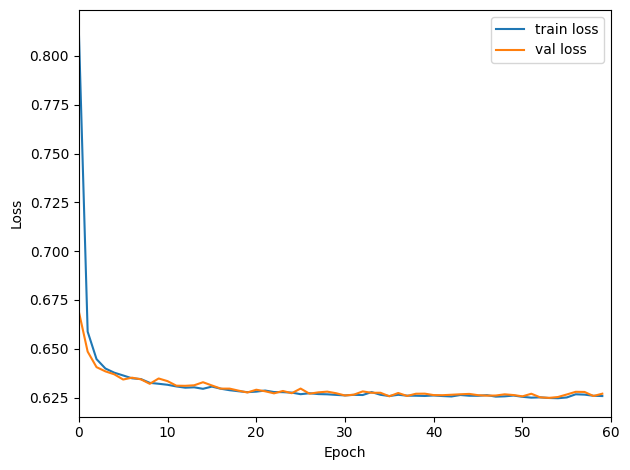

In [103]:
fig, ax = plt.subplots()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(diz_loss['train_loss'], label='train loss')
ax.plot(diz_loss['val_loss'], label='val loss')
ax.legend()
ax.set_xlim(0, num_epochs)


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

In [ ]:
encoder.eval()
decoder.eval()

In [ ]:
sumf = 0
for i in range(6400):
    img = test_dataset[i][0].unsqueeze(0).numpy()
    suming = np.sum(img)
    if suming>sumf:
        sumf = sumimg
        idx = i
print(i)
print(sumf)

6399
2.0


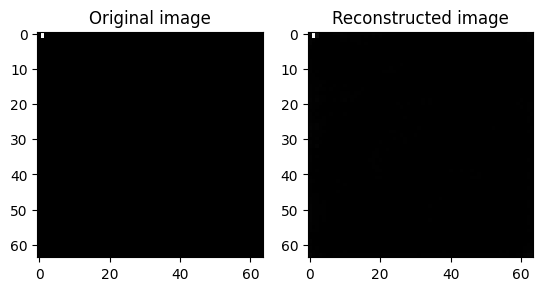

In [ ]:
# evaluate model on radoom image
img = test_dataset[999][0].unsqueeze(0)
with torch.no_grad():
    rec_img = decoder(encoder(img))
    rec_img = rec_img.squeeze().numpy()
    img = img.squeeze().numpy()
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(rec_img, cmap='gray')
    ax[1].set_title('Reconstructed image')

In [ ]:
# Function to save the model
def save_model(encoder, decoder, encoder_path="encoder.pth", decoder_path="decoder.pth"):
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(decoder.state_dict(), decoder_path)
    print("Models saved to {} and {}".format(encoder_path, decoder_path))

save_model(encoder, decoder, encoder_path="encoder_64x64.pth", decoder_path="decoder_init_64x64.pth")

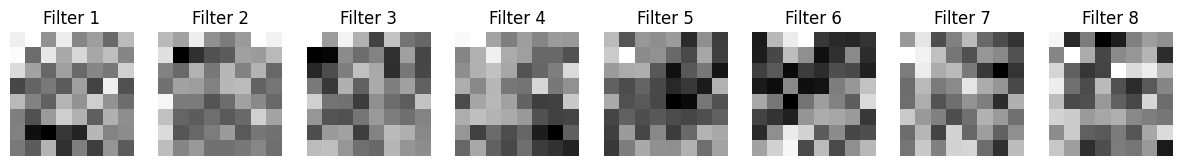

In [105]:
def plot_initial_convolutions(encoder, num_filters=8, figsize=(15, 15)):
    """
    Plots the initial convolutional filters of the encoder.
    
    Parameters:
    - encoder: The trained encoder model.
    - num_filters: Number of filters to plot. Default is 16.
    - figsize: Size of the plot. Default is (15, 15).
    """
    # Extract the weights from the first convolutional layer
    conv1_weights = encoder.encoder_cnn[0].weight.data.cpu().numpy()
    
    # Create a figure to plot the filters
    fig, axes = plt.subplots(1, num_filters, figsize=figsize)
    
    for i in range(num_filters):
        ax = axes[i]
        # Get the filter
        filt = conv1_weights[i, 0, :, :]
        # Plot the filter
        ax.imshow(filt, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    
    plt.show()

# Usage example
plot_initial_convolutions(encoder)
